<a href="https://colab.research.google.com/github/akatic47/Paralelni_algoritmi/blob/main/Drugi_projekat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycuda

In [2]:
!nvidia-smi

Thu Dec 11 18:02:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P8             22W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
def diffuse_cpu(conc,decay):
    h, w = conc.shape
    conc_pad = np.pad(conc, 1, mode='constant', constant_values=0)
    conc_new = conc.copy()

    for i in range(h):
        for j in range(w):
            ip = i + 1
            jp = j + 1
            neighbors = [
                conc_pad[ip, jp],
                conc_pad[ip, jp - 1],
                conc_pad[ip, jp + 1],
                conc_pad[ip - 1, jp],
                conc_pad[ip + 1, jp]
            ]
            conc_new[i][j] = sum(neighbors) / 5 * (1-decay)

    return conc_new


In [4]:
def apply_sources_cleaners_cpu(conc, cell_type):
    h, w = conc.shape
    conc_new = conc.copy()

    for i in range(h):
        for j in range(w):
            if cell_type[i][j] == 1:
                conc_new[i][j] = source_value
            elif cell_type[i][j] == 2:
                conc_new[i][j] = absorb_value

    return conc_new


In [16]:
conc = np.zeros((h, w), dtype=np.float32)

for a in range(t):
    conc = diffuse_cpu(conc,decay)
    conc = apply_sources_cleaners_cpu(conc, cell_type)

    plt.imshow(conc, cmap='hot', interpolation='nearest')
    plt.title(f"Iteracija {a+1}")
    plt.colorbar()
    plt.show()


NameError: name 'cell_type' is not defined

Prvi zadatak

In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import math

In [17]:
cell_type = np.zeros((h,w), dtype=np.uint8)
for i in range(h):
  for j in range(w):
    cell_type[i][j] = random.choices([0, 1, 2], weights=[10, 1, 1])[0]

In [18]:
def cuda_alloc(*args):
  return [cuda.mem_alloc(arg.nbytes) for arg in args]


def to_cuda(*args):
  cuda_ptrs = cuda_alloc(*args)
  for dst, src in zip(cuda_ptrs, args):
     cuda.memcpy_htod(dst, src)
  return cuda_ptrs

In [19]:
mod = SourceModule("""
__global__ void diffusion_step_kernel(float *conc_pad, float *conc_new,
                                      int h, int w, float decay)
{
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;

    if (x >= w || y >= h) return;

    int pad_w = w + 2;
    int pad_x = x + 1;
    int pad_y = y + 1;

    int center = pad_x + pad_y * pad_w;

    float centar  = conc_pad[center];
    float levo  = conc_pad[center - 1];
    float desno  = conc_pad[center + 1];
    float gore  = conc_pad[center - pad_w];
    float dole  = conc_pad[center + pad_w];

    float avg = (centar + levo + desno + gore + dole ) / 5;
    float out = avg * (1 - decay);

    conc_new[y * w + x] = out;
}
""")

diffusion_step_kernel = mod.get_function("diffusion_step_kernel")



In [20]:
mod = SourceModule("""
__global__ void apply_sources_cleaners_kernel(
        unsigned char *cell_type,
        float *conc,
        int h, int w,
        float source_value,
        float absorb_value)
{
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;

    if (x >= w || y >= h) return;

    int idx = y * w + x;

    unsigned char t = cell_type[idx];

    if (t == 1) {
        conc[idx] = source_value;
    }
    else if (t == 2) {
        conc[idx]-=absorb_value;
        if(conc[idx] < 0) conc[idx] = 0;
    }
}
""")

apply_sources_cleaners_kernel = mod.get_function("apply_sources_cleaners_kernel")


Drugi zadatak

In [21]:
mod = SourceModule("""
__global__ void count_danger_kernel(
        float *conc,
        int *danger_count,
        float danger_threshold,
        int h, int w)
{
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;

    if (x >= w || y >= h) return;

    int idx = y * w + x;

    if (conc[idx] >= danger_threshold)
      danger_count[idx]++;

}
""")

count_danger_kernel = mod.get_function("count_danger_kernel")


In [22]:
mod = SourceModule("""
__global__ void count_ever_dangerous_kernel(
        int *danger_count,
        int *danger_counter,
        int h, int w)
{
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;

    if (x >= w || y >= h) return;

    int idx = y * w + x;

    if (danger_count[idx] > 0)
      atomicAdd(danger_counter,1);

}
""")

count_ever_dangerous_kernel = mod.get_function("count_ever_dangerous_kernel")


In [23]:
conc = np.zeros((h, w), dtype=np.float32)
conc_gpu = cuda.mem_alloc(conc.nbytes)
cuda.memcpy_htod(conc_gpu, conc)

cell_type_gpu = cuda.mem_alloc(cell_type.nbytes)
cuda.memcpy_htod(cell_type_gpu, cell_type)

danger_count = np.zeros((h,w), dtype = np.int32)
danger_count_gpu = cuda.mem_alloc(danger_count.nbytes)
cuda.memcpy_htod(danger_count_gpu,danger_count)


danger_counter = np.zeros(1, dtype=np.int32)
danger_counter_gpu = cuda.mem_alloc(danger_counter.nbytes)
cuda.memcpy_htod(danger_counter_gpu, danger_counter)

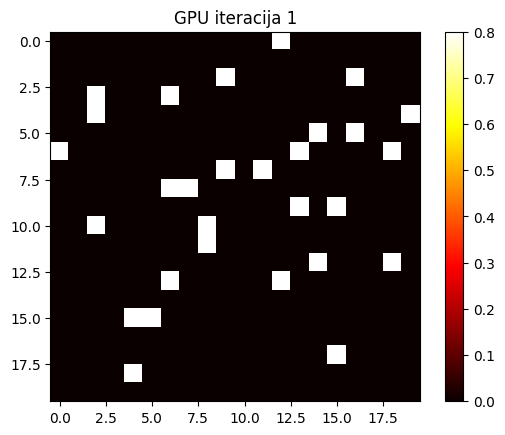

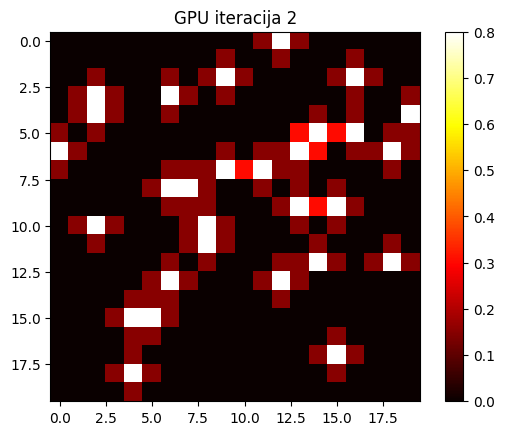

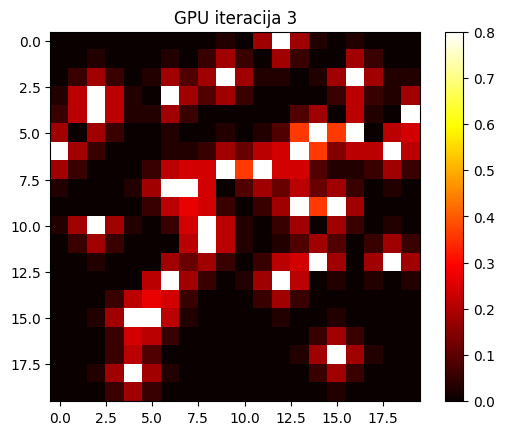

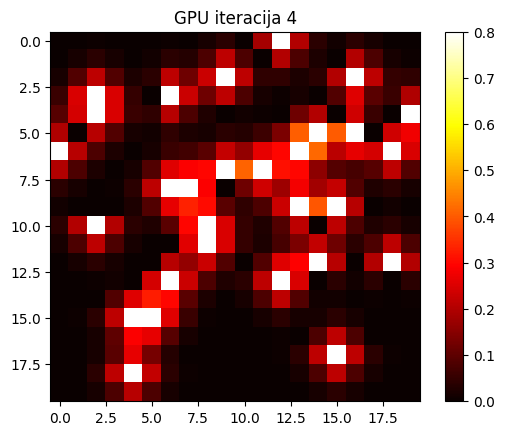

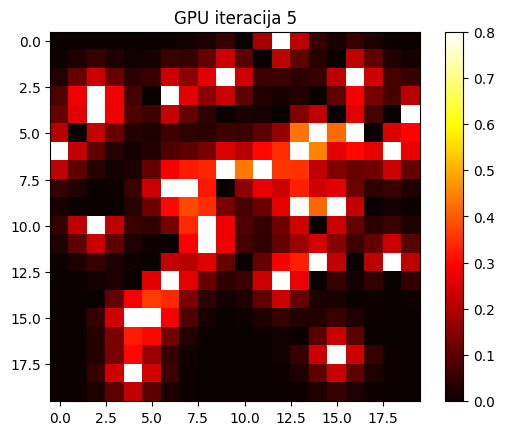

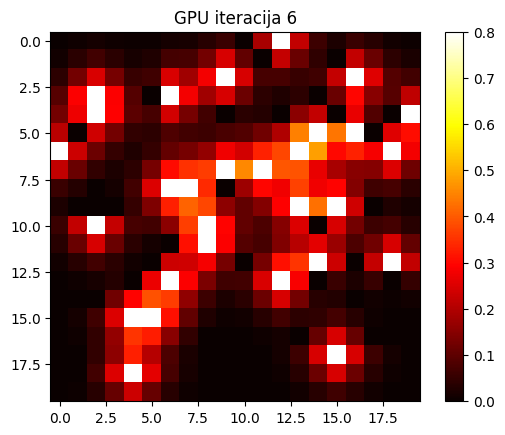

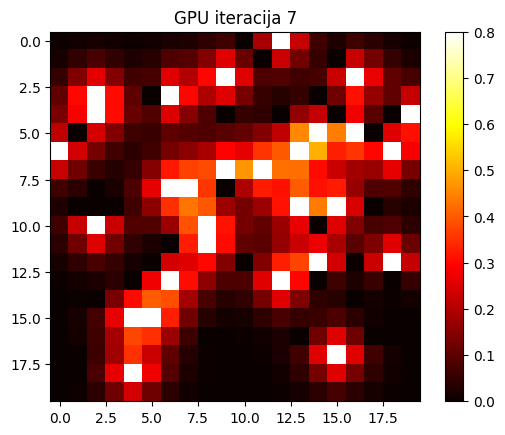

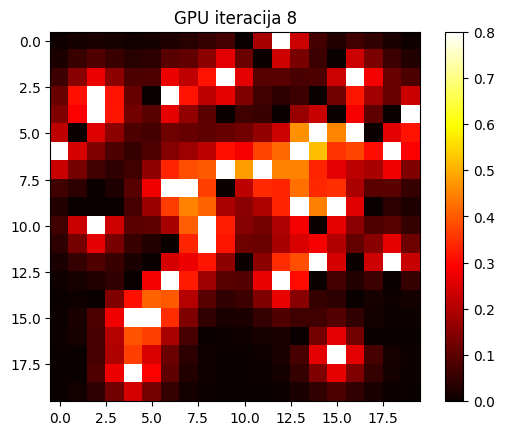

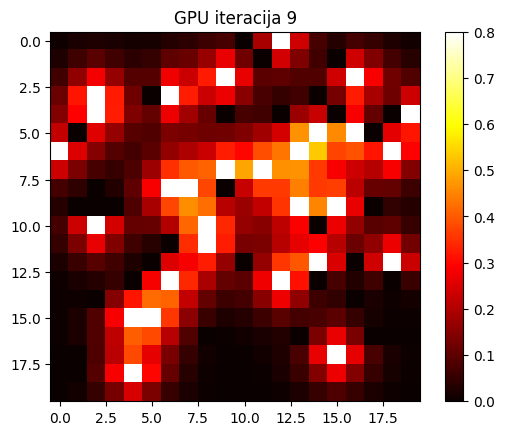

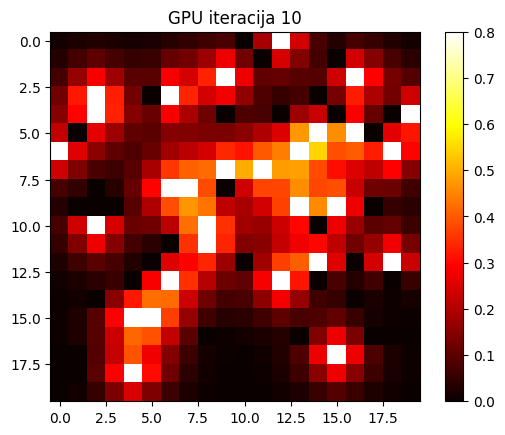

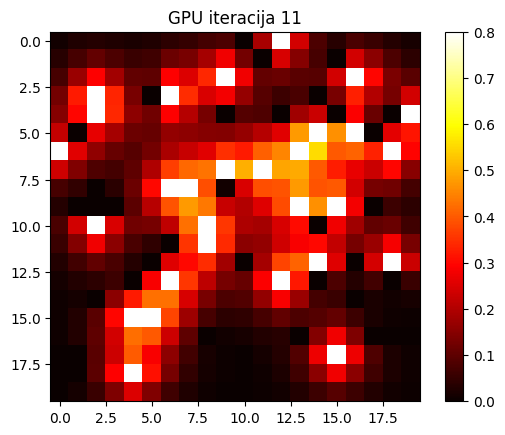

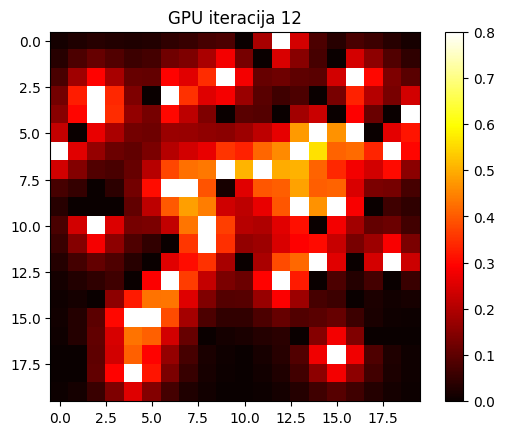

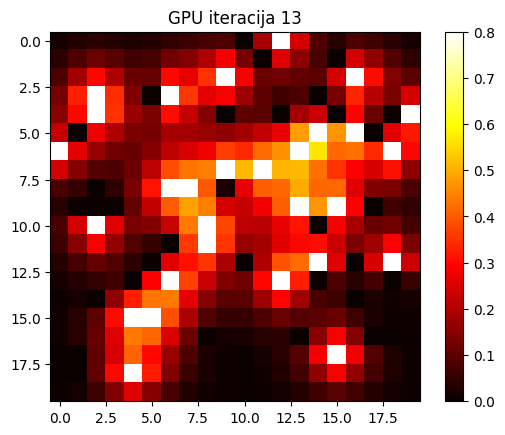

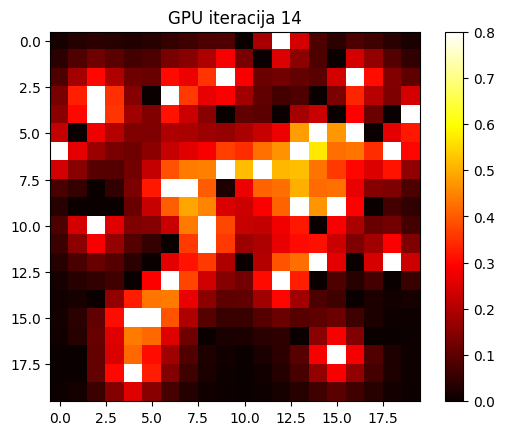

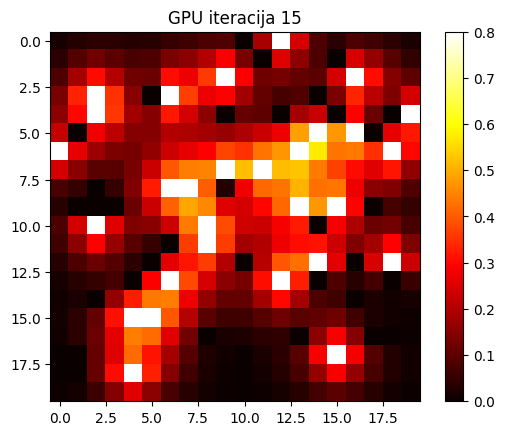

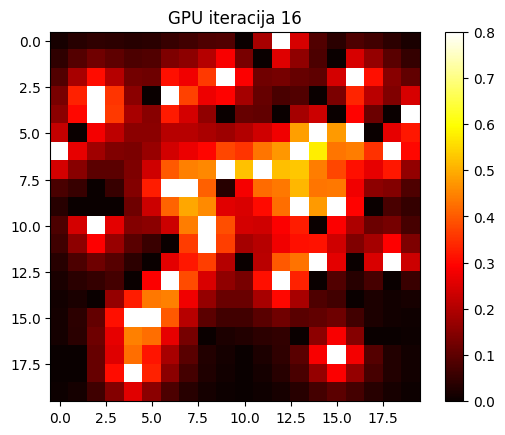

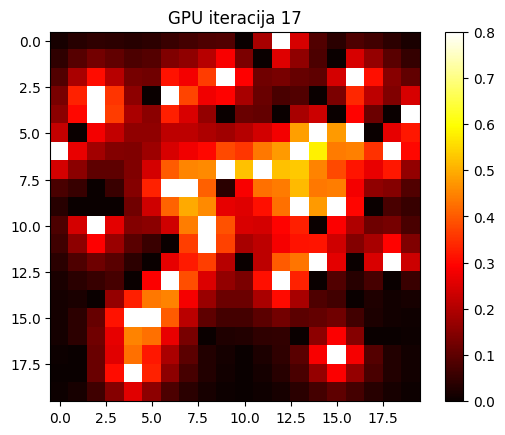

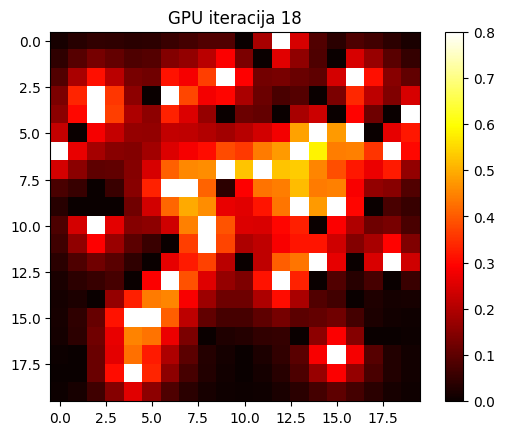

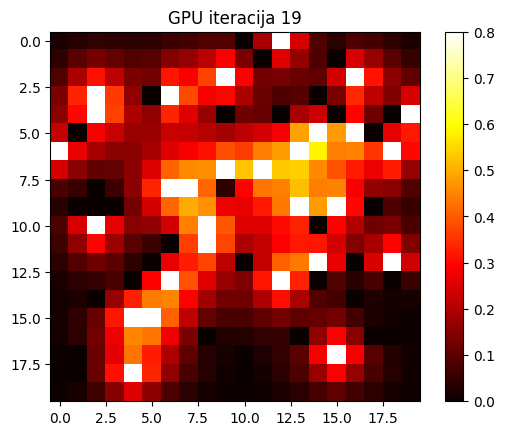

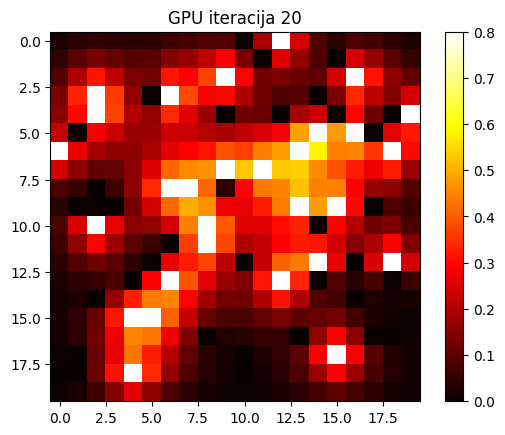

[[ 0  0  0  0  0  0  0  0  0  0  0  0 20 17  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6 17  0  0 17  0  0  0 17  0  0  0]
 [ 0  0 17  6  0  0 17 14 17 20 17  0  0  0  0 17 20 17  0  0]
 [ 0 18 20 18  0  0 20 17 13 17  0  0  0  0  0  0 18 10  0 16]
 [ 0 18 20 18  1  0 17 10  0  0  0  0  0  0 17  0 18  0  0 20]
 [16  0 17  7  0  0  6  5  3  0  5 10 14 19 20 19 20  0 18 18]
 [20 17  0  0  0  0  9 11 13 17 16 18 18 20 19 17 18 18 20 18]
 [17  0  0  0  0  9 18 18 18 20 19 20 18 18 16 14 13 12 17  0]
 [ 0  0  0  0  0 17 20 20 18  0 13 17 16 18 16 17 12  0  0  0]
 [ 0  0  0  0  0 10 18 18 18 12 10 12 17 20 19 20 17  0  0  0]
 [ 0 17 20 17  0  0 12 18 20 18  9  8 12 17  0 17  2  0  0  0]
 [ 0  0 17  0  0  0  0 18 20 18  0  6 12 15 17 13  0  0 17  0]
 [ 0  0  0  0  0  0 17 16 17  6  0  7 18 18 20 17  0 17 20 17]
 [ 0  0  0  0  0 18 20 17 11  0  0 17 20 18  0  0  0  0  0  0]
 [ 0  0  0  0 18 18 18 13  0  0  0  0 17  0  0  0  0  0  0  0]
 [ 0  0  0 17 20 20 18  6  0  0  0  0  0  0  0  0  0  0

In [24]:
for a in range(t):

    conc_pad = np.pad(conc, (1, 1), mode='constant', constant_values=0).astype(np.float32)
    conc_pad_gpu = cuda.mem_alloc(conc_pad.nbytes)
    cuda.memcpy_htod(conc_pad_gpu, conc_pad)


    diffusion_step_kernel(
        conc_pad_gpu, conc_gpu,
        np.int32(h), np.int32(w), np.float32(decay),
        block=(32, 32, 1),
        grid=(math.ceil(w/32), math.ceil(h/32), 1)
    )

    apply_sources_cleaners_kernel(
        cell_type_gpu, conc_gpu,
        np.int32(h), np.int32(w),
        np.float32(source_value), np.float32(absorb_value),
        block=(32, 32, 1),
        grid=(math.ceil(w/32), math.ceil(h/32), 1)
    )

    count_danger_kernel(
        conc_gpu,
        danger_count_gpu,
        np.float32(danger_threshold),
        np.int32(h),
        np.int32(w),
        block=(32, 32, 1),
        grid=(math.ceil(w/32), math.ceil(h/32), 1)
    )

    cuda.memcpy_dtoh(conc, conc_gpu)

    plt.imshow(conc, cmap='hot', interpolation='nearest')
    plt.title(f"GPU iteracija {a+1}")
    plt.colorbar()
    plt.show()



cuda.memcpy_dtoh(danger_count,danger_count_gpu)
print(danger_count)


count_ever_dangerous_kernel(
    danger_count_gpu,
    danger_counter_gpu,
    np.int32(h),
    np.int32(w),
    block=(32, 32, 1),
    grid=(math.ceil(w/32), math.ceil(h/32), 1)
)

cuda.memcpy_dtoh(danger_counter, danger_counter_gpu)
print("Broj ćelija koje su ikada bile opasne:", danger_counter[0])


Treci zadatak

In [25]:
mod = SourceModule("""
__global__ void region_hotspot_stats_kernel(
        int *danger_count,
        float *region_means,
        float *region_std_devs,
        int h, int w,
        int r, int c)
{
    int velicina_regiona = r*c;
    int id = threadIdx.x;

    extern __shared__ unsigned char shared[];

    int *danger_local = (int*) shared;
    float *reduce_buf = (float*) (danger_local + velicina_regiona);

    // lokalne koordinate
    int local_i = id / c;
    int local_j = id % c;

    // globalne
    int global_i = blockIdx.y * r + local_i;
    int global_j = blockIdx.x * c + local_j;
    int global_id = global_i * w + global_j;

    danger_local[id] = danger_count[global_id];
    __syncthreads();

    reduce_buf[id] = (float) danger_local[id];
    __syncthreads();



    // tree reduction
    // "stride >>= 1" -  bit shift (isto mu dodje kao /2)
    for (int stride = velicina_regiona / 2; stride > 0; stride >>= 1) {
        //prvoj polovini clanova dodamo drugu
        if (id < stride) {
            reduce_buf[id] += reduce_buf[id + stride];
        }
        __syncthreads();
    }

    // racunanje formule
    // na id = 0 se nalazi zbir svih clanova
    if (id == 0) {
        float suma = reduce_buf[0];
        float mean = suma / (float) velicina_regiona;

        // upis rezultata za ovaj region
        int region_index = blockIdx.y * gridDim.x + blockIdx.x;
        region_means[region_index] = mean;

        // mean ide u shared memoriju za drugi zadatak
        reduce_buf[0] = mean;
    }

    // da svi stignu da dobiju mean iz reduce_buf[0]
    __syncthreads();

    float mean_val = reduce_buf[0];

    float razlika = (float)danger_local[id] - mean_val;

    //punimo nazad buffer i opet cekamo sve niti da ga napune
    reduce_buf[id] = razlika * razlika;
    __syncthreads();


    // tree reduction
    // "stride >>= 1" -  bit shift (isto mu dodje kao /2)
    for (int stride = velicina_regiona / 2; stride > 0; stride >>= 1) {
        //prvoj polovini clanova dodamo drugu
        if (id < stride) {
            reduce_buf[id] += reduce_buf[id + stride];
        }
        __syncthreads();
    }


     if (id == 0) {
        float suma_kvadrata = reduce_buf[0];
        float varijansa = suma_kvadrata / (float)velicina_regiona;
        float std_dev = sqrtf(varijansa);

        int region_index = blockIdx.y * gridDim.x + blockIdx.x;

        region_std_devs[region_index] = std_dev;
    }

}
""")

region_hotspot_stats_kernel = mod.get_function("region_hotspot_stats_kernel")


In [41]:
mod = SourceModule("""
__global__ void mark_hotspots_kernel(
        int *danger_count,
        float *region_means,
        float *region_std_devs,
        unsigned char *is_hotspot,
        int h, int w,
        int r, int c,
        float alpha)
{
    int velicina_regiona = r * c;
    int id = threadIdx.x;

    // lokalne koordinate unutar regiona
    int local_i = id / c;
    int local_j = id % c;

    // globalne koordinate u celoj matrici
    int global_i = blockIdx.y * r + local_i;
    int global_j = blockIdx.x * c + local_j;


    int global_id = global_i * w + global_j;

    // indeks regiona
    int region_index = blockIdx.y * gridDim.x + blockIdx.x;
    float mean_val = region_means[region_index];
    float std_val  = region_std_devs[region_index];

    float threshold = mean_val + alpha * std_val;

    int danger = danger_count[global_id];

    is_hotspot[global_id] = (danger > threshold) ? 1 : 0;
}
""")

mark_hotspots_kernel = mod.get_function("mark_hotspots_kernel")


In [28]:
region_means = np.zeros(grid_x * grid_y, dtype=np.float32)
region_means_gpu = cuda.mem_alloc(region_means.nbytes)
cuda.memcpy_htod(region_means_gpu, region_means)

region_std_devs = np.zeros(grid_x * grid_y, dtype=np.float32)
region_std_devs_gpu = cuda.mem_alloc(region_std_devs.nbytes)
cuda.memcpy_htod(region_std_devs_gpu, region_std_devs)


is_hotspot = np.zeros_like(danger_count, dtype=np.uint8)
is_hotspot_gpu = cuda.mem_alloc(is_hotspot.nbytes)
cuda.memcpy_htod(is_hotspot_gpu, is_hotspot)

Mean vrednosti po regionima:
 [[ 3.88  5.    2.04  4.12]
 [ 2.28  7.28 10.28  8.72]
 [ 2.04  7.96  6.28  2.92]
 [ 4.16  3.28  0.    1.48]]


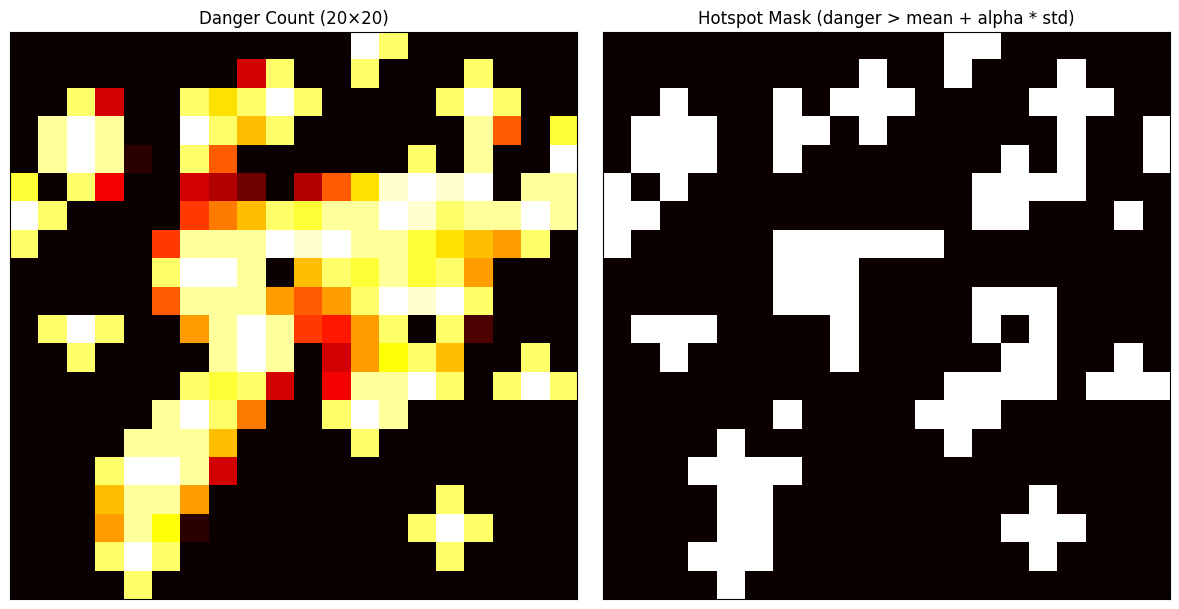

In [45]:
shared_bytes = (r * c) * (np.int32().nbytes + np.float32().nbytes)

region_hotspot_stats_kernel(
    danger_count_gpu,
    region_means_gpu,
    region_std_devs_gpu,
    np.int32(h),
    np.int32(w),
    np.int32(r),
    np.int32(c),
    block=(r * c, 1, 1),
    grid=(grid_x, grid_y, 1),
    shared=shared_bytes
)

mark_hotspots_kernel(
    danger_count_gpu,
    region_means_gpu,
    region_std_devs_gpu,
    is_hotspot_gpu,
    np.int32(h),
    np.int32(w),
    np.int32(r),
    np.int32(c),
    alpha,
    block=(r * c, 1, 1),
    grid=(grid_x, grid_y, 1)
)



cuda.memcpy_dtoh(region_means, region_means_gpu)
print("Mean vrednosti po regionima:\n", region_means.reshape(grid_y, grid_x))
cuda.memcpy_dtoh(region_std_devs, region_std_devs_gpu)
cuda.memcpy_dtoh(is_hotspot, is_hotspot_gpu)


# ---------------------- PLOTOVI -----------------------------
fig, axs = plt.subplots(1,2, figsize=(12, 6))

# 1 — Original danger matrix
axs[0].imshow(danger_count, cmap="hot", interpolation="nearest")
axs[0].set_title("Danger Count (20×20)")
axs[0].set_xticks([]); axs[0].set_yticks([])


# 4 — Hotspot mask (GPU rezultat)
axs[1].imshow(is_hotspot, cmap="hot", interpolation="nearest")
axs[1].set_title("Hotspot Mask (danger > mean + alpha * std)")
axs[1].set_xticks([]); axs[1].set_yticks([])

plt.tight_layout()
plt.show()


In [44]:
h = 20
w = 20

t = 20
decay = 0.05
source_value = 0.8
absorb_value = 0.3

danger_threshold = 0.2

r = 5
c = 5

grid_x = int(w/c)
grid_y = int(h/r)

block = (r*c,1,1)
alpha = np.float32(1.5)

